<a href="https://colab.research.google.com/github/gonzaq94/NER-LLM-classification/blob/main/fine_tune_BERT_dataset_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import comet_ml
import comet_llm
import os
import gdown
from datasets import load_dataset
import random
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

Read API key

## Load dataset

Take 1000 random examples of the CONLL dataset.

In [ ]:
# Load the CONLL dataset
dataset_train = load_dataset("conll2003", split="train").shuffle().select(range(1000))
dataset_valid = load_dataset("conll2003", split="validation").shuffle().select(range(1000))
dataset_test = load_dataset("conll2003", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
print(dataset_train)
print(dataset_valid)

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 1000
})
Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 1000
})


In [ ]:
for i in range(5):
    print(dataset_train[i])

{'id': '11127', 'tokens': ['The', 'formal', 'inauguration', 'had', 'been', 'due', 'to', 'take', 'place', 'this', 'week', 'but', 'was', 'put', 'back', '.'], 'pos_tags': [12, 16, 21, 38, 40, 16, 35, 37, 37, 12, 21, 10, 38, 40, 30, 7], 'chunk_tags': [11, 12, 12, 21, 22, 1, 21, 22, 22, 11, 12, 0, 21, 22, 3, 0], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': '4471', 'tokens': ['GOLF', '-', 'MICKELSON', 'WINS', 'FOURTH', 'TITLE', 'OF', 'YEAR', 'IN', 'AKRON', '.'], 'pos_tags': [21, 8, 22, 42, 15, 12, 15, 21, 15, 22, 7], 'chunk_tags': [11, 0, 11, 21, 13, 11, 12, 12, 13, 11, 0], 'ner_tags': [0, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0]}
{'id': '7685', 'tokens': ['With', 'your', 'help', 'we', 'can', 're-elect', 'Bill', 'Clinton', '.', '"'], 'pos_tags': [15, 29, 21, 28, 20, 37, 22, 22, 7, 0], 'chunk_tags': [13, 11, 12, 11, 21, 22, 11, 12, 12, 0], 'ner_tags': [0, 0, 0, 0, 0, 0, 1, 2, 0, 0]}
{'id': '10958', 'tokens': ['The', 'August', 'contract', 'expired', 'at', '0.85', 'cent', 'down', '

 ## Load BERT model

Train a BERT on this dataset to classify tokens (the ner_tags column). Report performance.

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=9)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dataset preparation

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        tokens = []
        tokens_labels = []
        attention_masks = []

        for word, label in zip(text, labels):
          # Tokenize each word
          word_encoding = self.tokenizer(
              word,
              add_special_tokens=False,
              max_length=self.max_length,
              truncation=True,
              return_tensors="pt"
          )

          tokens.extend(word_encoding['input_ids'][0].tolist())
          attention_masks.extend(word_encoding['attention_mask'][0].tolist())
          tokens_labels.extend([label] * len(word_encoding['input_ids'][0]))

        # add padding
        padding_len = self.max_length - len(tokens)
        tokens += [0] * padding_len
        attention_masks += [0] * padding_len
        tokens_labels += [-100] * padding_len

        return {
            'input_ids': torch.tensor(tokens).flatten(),
            'attention_mask': torch.tensor(attention_masks).flatten(),
            'labels': torch.tensor(tokens_labels).flatten()
        }


In [ ]:
train_custom_dataset = CustomDataset(
    texts=dataset_train['tokens'],
    labels=dataset_train['ner_tags'],
    tokenizer=tokenizer,
    max_length=256
)

valid_custom_dataset = CustomDataset(
    texts=dataset_valid['tokens'],
    labels=dataset_valid['ner_tags'],
    tokenizer=tokenizer,
    max_length=256
)

## Fine-tune model

In [ ]:
# log results and assets to Comet
os.environ["COMET_LOG_ASSETS"] = "True"
os.environ["COMET_WORKSPACE"] = "gonzaq94"
os.environ["COMET_PROJECT_NAME"] = "ner_classif-bert-2"
os.environ["COMET_GIT_DIRECTORY"] = "https://github.com/gonzaq94/NER-LLM-classification"

In [ ]:
# reload model
model_name = 'bert-base-uncased'
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=9)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=24,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    dataloader_drop_last=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_custom_dataset,
    eval_dataset=valid_custom_dataset,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

COMET INFO: An experiment with the same configuration options is already running and will be reused.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.378700,0.813870,0.793627,0.702334,0.802354,0.793627
2,0.619500,0.375166,0.878261,0.858744,0.874123,0.878261
3,0.303900,0.229334,0.929480,0.922165,0.932523,0.929480
4,0.161900,0.161400,0.953967,0.951871,0.953930,0.953967
5,0.097900,0.166978,0.952149,0.951655,0.956888,0.952149
6,0.055800,0.147061,0.962094,0.961936,0.962418,0.962094
7,0.036700,0.142508,0.964927,0.965209,0.965974,0.964927
8,0.024100,0.156080,0.964981,0.965619,0.966669,0.964981
9,0.020400,0.144489,0.969686,0.969342,0.969835,0.969686
10,0.015700,0.137140,0.970701,0.970611,0.970832,0.970701


KeyboardInterrupt: 

 ## Evaluate the model

In [ ]:
def compute_metrics_eval(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions, normalize='true')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix
    }


class Evaluator:
    def __init__(self, model, tokenizer, compute_metrics):
        self.model = model
        self.tokenizer = tokenizer
        self.compute_metrics = compute_metrics

    def evaluate(self, eval_dataset, batch_size=16):
        trainer = Trainer(
            model=self.model,
            args=training_args,
            compute_metrics=self.compute_metrics,
            eval_dataset=eval_dataset,
        )
        return trainer.evaluate()

In [ ]:
evaluator = Evaluator(model, tokenizer, compute_metrics_eval)
eval_results = evaluator.evaluate(valid_custom_dataset)

COMET INFO: An experiment with the same configuration options is already running and will be reused.
COMET WARNING: Cannot safely convert array([[9.91107518e-01, 7.41040151e-04, 2.02101859e-04, 2.02101859e-03,
        1.27997844e-03, 1.34734573e-04, 2.02101859e-04, 2.89679332e-03,
        1.41471302e-03],
       [5.94530321e-03, 9.63139120e-01, 9.51248514e-03, 9.51248514e-03,
        0.00000000e+00, 8.32342449e-03, 0.00000000e+00, 3.56718193e-03,
        0.00000000e+00],
       [3.96825397e-03, 1.19047619e-02, 9.65608466e-01, 1.58730159e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.64550265e-03,
        0.00000000e+00],
       [2.83911672e-02, 2.99684543e-02, 3.15457413e-03, 8.67507886e-01,
        4.73186120e-03, 5.04731861e-02, 0.00000000e+00, 1.57728707e-02,
        0.00000000e+00],
       [1.19122257e-01, 6.26959248e-03, 2.19435737e-02, 5.95611285e-02,
        7.61755486e-01, 1.25391850e-02, 1.56739812e-02, 0.00000000e+00,
        3.13479624e-03],
       [3.8709677

In [ ]:
for key, value in eval_results.items():
  if key != 'eval_confusion_matrix':
    print(f"{key}: {value}")

eval_loss: 0.14644870162010193
eval_model_preparation_time: 0.0138
eval_accuracy: 0.9717707442258341
eval_f1: 0.9717443625198972
eval_precision: 0.9719172534270535
eval_recall: 0.9717707442258341
eval_runtime: 17.8971
eval_samples_per_second: 55.875
eval_steps_per_second: 3.52


In [ ]:
def plot_confusion_matrix(cm, class_names):

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

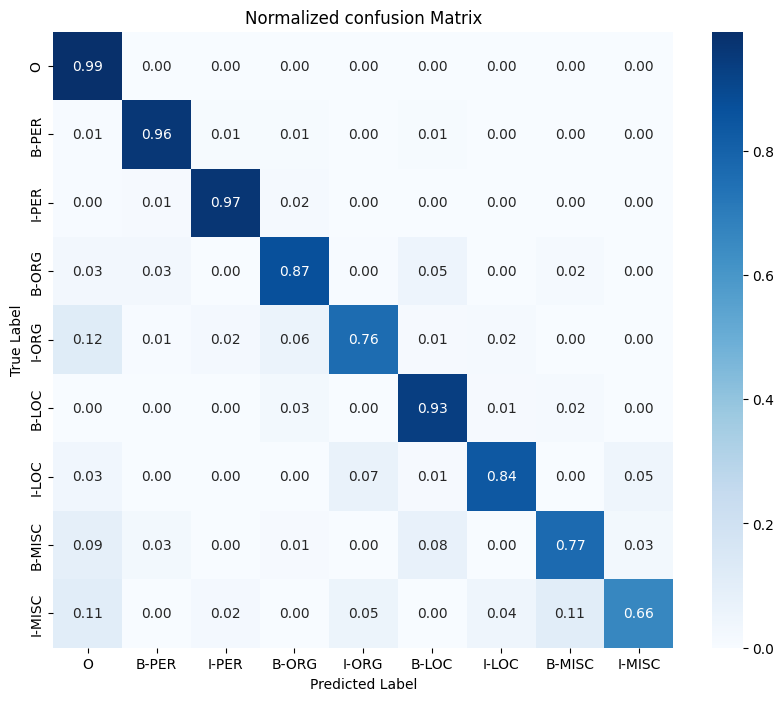

In [ ]:
labels_dct = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
class_names = [k for k, v in labels_dct.items()]
plot_confusion_matrix(eval_results['eval_confusion_matrix'], class_names)

## Registry model

In [ ]:
experiment = comet_ml.ExistingExperiment(api_key=COMET_API_KEY, previous_experiment="04862a2a88704c2fba3522d9acfb9564")
experiment.log_model("BERT-base-NER-1k-bs_24-last", "results/checkpoint-588")
experiment.register_model("BERT-base-NER-1k-bs_24-last")

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : intense_adapter_2598
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-2/04862a2a88704c2fba3522d9acfb9564
COMET INFO:   Uploads:
COMET INFO:     model-element : 3 (7.06 KB)
COMET INFO: 
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gonzaq94/ner-classif-bert-2/04862a2a88704c2fba3522d9acfb9564



## Deploy model

In [ ]:
from comet_ml import API

api = API(api_key=COMET_API_KEY)
COMET_WORKSPACE = "gonzaq94"


# model name
model_name = "BERT-base-NER-1k-bs_24-last"

#get the Model object
model = api.get_model(workspace=COMET_WORKSPACE, model_name=model_name)

# Download a Registry Model:
model.download("1.0.0", "./deploy", expand=True)

COMET INFO: Remote Model 'gonzaq94/BERT-base-NER-1k-bs_24-last:1.0.0' download has been started asynchronously.
COMET INFO: Still downloading 9 file(s), remaining 415.47 MB/415.47 MB
COMET WARNING: File './deploy/checkpoint-588/rng_state.pth' has been overwritten by asset '30d89e8ba7754e538f5e00e0b966f94a' of remote model
COMET WARNING: File './deploy/checkpoint-588/scheduler.pt' has been overwritten by asset '0f1700e00a42436bbd4fc706563c5bb4' of remote model
COMET WARNING: File './deploy/checkpoint-588/config.json' has been overwritten by asset '08fe1243f6d642bead4c8cf22a840137' of remote model
COMET WARNING: File './deploy/checkpoint-588/config.json' has been overwritten by asset '24957ce56c7e4b789a6c9999042d6ac8' of remote model
COMET WARNING: File './deploy/checkpoint-588/training_args.bin' has been overwritten by asset '3dd7aee75ea94f069c28dfa77a1f6871' of remote model
COMET WARNING: File './deploy/checkpoint-588/trainer_state.json' has been overwritten by asset 'c3cbead9cfee40deb

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("./deploy/checkpoint-588", num_labels=9)

In [ ]:
evaluator = Evaluator(model, tokenizer, compute_metrics_eval)
eval_results = evaluator.evaluate(test_custom_dataset)

COMET INFO: An experiment with the same configuration options is already running and will be reused.
COMET WARNING: Cannot safely convert array([[9.91174885e-01, 7.41040151e-04, 2.02101859e-04, 1.75154945e-03,
        1.21261116e-03, 1.34734573e-04, 2.02101859e-04, 3.09889518e-03,
        1.48208030e-03],
       [5.94530321e-03, 9.54815696e-01, 9.51248514e-03, 1.30796671e-02,
        2.37812128e-03, 1.07015458e-02, 0.00000000e+00, 3.56718193e-03,
        0.00000000e+00],
       [3.96825397e-03, 1.32275132e-02, 9.64285714e-01, 1.58730159e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.64550265e-03,
        0.00000000e+00],
       [2.99684543e-02, 2.52365931e-02, 3.15457413e-03, 8.69085174e-01,
        4.73186120e-03, 5.20504732e-02, 0.00000000e+00, 1.57728707e-02,
        0.00000000e+00],
       [1.22257053e-01, 6.26959248e-03, 2.19435737e-02, 5.95611285e-02,
        7.49216301e-01, 1.25391850e-02, 1.88087774e-02, 0.00000000e+00,
        9.40438871e-03],
       [3.8709677

In [ ]:
for key, value in eval_results.items():
  if key != 'eval_confusion_matrix':
    print(f"{key}: {value}")

eval_loss: 0.1464821696281433
eval_model_preparation_time: 0.0137
eval_accuracy: 0.9711291702309667
eval_f1: 0.9711212303632004
eval_precision: 0.9713346140071276
eval_recall: 0.9711291702309667
eval_runtime: 16.8615
eval_samples_per_second: 59.307
eval_steps_per_second: 3.736


# Fine-tune with different train size

In [ ]:
from google.colab import userdata

# log results and assets to Comet
os.environ["COMET_LOG_ASSETS"] = "True"
os.environ["COMET_PROJECT_NAME"] = "ner_classif-bert-diff_train_size-constant_its"
os.environ["COMET_GIT_DIRECTORY"] = "https://github.com/gonzaq94/NER-LLM-classification"
os.environ["COMET_WORKSPACE"] = userdata.get('COMET_WORKSPACE')
os.environ["COMET_API_KEY"] = userdata.get('COMET_API_KEY')

In [ ]:
# Load the CONLL dataset
dataset_train = load_dataset("conll2003", split="train")
dataset_valid = load_dataset("conll2003", split="validation")
dataset_test = load_dataset("conll2003", split="test")

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        tokens = []
        tokens_labels = []
        attention_masks = []

        for word, label in zip(text, labels):
          # Tokenize each word
          word_encoding = self.tokenizer(
              word,
              add_special_tokens=False,
              max_length=self.max_length,
              truncation=True,
              return_tensors="pt"
          )

          tokens.extend(word_encoding['input_ids'][0].tolist())
          attention_masks.extend(word_encoding['attention_mask'][0].tolist())
          tokens_labels.extend([label] * len(word_encoding['input_ids'][0]))

        # add padding
        padding_len = self.max_length - len(tokens)
        tokens += [0] * padding_len
        attention_masks += [0] * padding_len
        tokens_labels += [-100] * padding_len

        return {
            'input_ids': torch.tensor(tokens).flatten(),
            'attention_mask': torch.tensor(attention_masks).flatten(),
            'labels': torch.tensor(tokens_labels).flatten()
        }

In [ ]:
from transformers.integrations import CometCallback
from transformers import TrainerCallback

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def get_downsampled_datasets(orig_train_set, orig_valid_set, dsize):
  # downsample datasets
  ds_dataset_train = orig_train_set.shuffle().select(range(dsize))
  ds_dataset_valid = orig_valid_set.shuffle().select(range(dsize))

  train_custom_dataset = CustomDataset(
      texts=ds_dataset_train['tokens'],
      labels=ds_dataset_train['ner_tags'],
      tokenizer=tokenizer,
      max_length=256
  )

  valid_custom_dataset = CustomDataset(
      texts=ds_dataset_valid['tokens'],
      labels=ds_dataset_valid['ner_tags'],
      tokenizer=tokenizer,
      max_length=256
  )

  return train_custom_dataset, valid_custom_dataset

def get_trainer(niterations, experiment, model, train_ds, valid_ds, batch_size=24):

  class CustomCometCallback(CometCallback):

    def __init__(self, experiment):
        super().__init__()
        self._experiment = experiment

    """
    def on_train_end(self, args, state, control, **kwargs):
        if self._experiment:  # Check if the experiment exists
            self._experiment.end()  # Ends the experiment properly when training ends

    def on_log(self, args, state, control, logs=None, **kwargs):
        print(self._log_assets)
        if self._experiment and logs:  # Ensure experiment and logs are valid
            global_step = state.global_step  # Access the global_step from the state
            for key, value in logs.items():
                if isinstance(value, (int, float)):  # Check if the value is a scalar
                    self._experiment.log_metric(key, value, step=global_step)
    """
    """
    def on_train_end(self, args, state, control, **kwargs):
        self.experiment.end()  # Ends the experiment properly when training ends

    def on_log(self, args, state, control, logs=None, **kwargs):
        if self.experiment:
            global_step = state.global_step  # Access the global_step from the state
            for key, value in logs.items():
                self.experiment.log_metric(key, value, step=global_step)
    """

  training_args = TrainingArguments(
    output_dir='./results',
    max_steps=niterations,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    #num_train_epochs=nepochs,
    evaluation_strategy="steps",
    eval_steps=niterations // 15,
    save_strategy="steps",
    save_steps=niterations // 15,
    logging_strategy="no",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=niterations // 10,
    weight_decay=0.01,
    logging_dir=None,
    dataloader_drop_last=False,
    )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_ds,
      eval_dataset=valid_ds,
      compute_metrics=compute_metrics,
      callbacks=[CustomCometCallback(experiment=experiment)],
  )

  return trainer

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
!rm -r ./results

In [ ]:
import shutil
import os

#dataset_sizes = [100, 300, 1000]
dataset_sizes = [10, 30, 100, 300, 1000]
# set the same number of iterations for each run, so as to have 15 epochs for a training dataset of size 1000 and a batch size of 24
niterations = int((1000 / 24)*15)
#niterations = 2

for dsize in dataset_sizes:

  # define comet experiment
  experiment = comet_ml.Experiment(
    api_key=os.getenv("COMET_API_KEY"),
    project_name=os.getenv("COMET_PROJECT_NAME"),
    workspace=os.getenv("COMET_WORKSPACE"))

  experiment.set_name(f"train_size_{dsize}")

  # sample datasets
  train_ds, valid_ds = get_downsampled_datasets(dataset_train, dataset_valid, dsize)

  # reload model and trainer
  model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=9)
  trainer = get_trainer(niterations, experiment, model, train_ds, valid_ds, batch_size=24)

  # train
  trainer.train()

  # Copy the best model checkpoint to a "best_model" directory with a custom name
  best_model_dir = "./results/best_model"
  if os.path.exists(best_model_dir):
      shutil.rmtree(best_model_dir)  # Remove existing directory if needed
  os.makedirs(best_model_dir, exist_ok=True)
  shutil.copytree(trainer.state.best_model_checkpoint, best_model_dir, dirs_exist_ok=True)

  experiment.log_model(f"BERT-base-NER-size{dsize}", "results/best_model")
  experiment.register_model(f"BERT-base-NER-size{dsize}")

  # remove files
  shutil.rmtree('./results')

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : train_size_10
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-diff-train-size-constant-its/59a254c72b8542efa299710d4e48c987
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [2]                   : (41.0, 82.0)
COMET INFO:     eval/accuracy [2]           : (0.8421052631578947, 0.8526315789473684)
COMET INFO:     eval/f1 [2]                 : (0.7848086124401913, 0.8132181199266822)
COMET INFO:     eval/loss [2]               : (0.5484954714775085, 0.6174136996269226)
COMET INFO:     eval/precision [2]          : (0.8343017949498023, 0.8743490304709142)
COMET INFO:     eval/recall [2]             :

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
41,No log,0.555364,0.852632,0.784809,0.874349,0.852632
82,No log,0.591152,0.836842,0.831566,0.885479,0.836842
123,No log,0.676981,0.852632,0.864077,0.914261,0.852632
164,No log,0.662133,0.852632,0.861831,0.921502,0.852632
205,No log,0.704575,0.847368,0.847339,0.881843,0.847368
246,No log,0.730360,0.842105,0.840449,0.874826,0.842105
287,No log,0.741894,0.842105,0.840449,0.874826,0.842105
328,No log,0.764208,0.847368,0.844858,0.877014,0.847368
369,No log,0.777007,0.847368,0.844858,0.877014,0.847368
410,No log,0.789991,0.847368,0.844858,0.877014,0.847368


COMET INFO: Successfully registered 'BERT-base-NER-size10', version None in workspace 'gonzaq94'
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : train_size_10
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-diff-train-size-constant-its/d8e6b0491a484ddb82ae1132f8cd1ec6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [16]                     : (41.0, 625.0)
COMET INFO:     eval/accuracy [15]             : (0.8368421052631579, 0.8526315789473684)
COMET INFO:     eval/f1 [15]                   : (0.7848086124401913, 0.8640765550239233)
COMET INFO:     eval/loss [15]                 : (0.5553635954856873, 0.8132314682006836)
COMET INFO:     eval/p

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
41,No log,0.654209,0.830420,0.753485,0.859177,0.830420
82,No log,0.518351,0.856643,0.860685,0.884659,0.856643
123,No log,0.541775,0.865385,0.866640,0.888306,0.865385
164,No log,0.597560,0.868881,0.872302,0.897198,0.868881
205,No log,0.631545,0.867133,0.873561,0.901455,0.867133
246,No log,0.620654,0.870629,0.867509,0.880860,0.870629
287,No log,0.651629,0.872378,0.873114,0.899364,0.872378
328,No log,0.661134,0.868881,0.870943,0.898369,0.868881
369,No log,0.668408,0.870629,0.871504,0.897605,0.870629
410,No log,0.672235,0.870629,0.871818,0.892134,0.870629


COMET INFO: Successfully registered 'BERT-base-NER-size30', version None in workspace 'gonzaq94'
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : train_size_30
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-diff-train-size-constant-its/cb3ded810da249a497f8dd9ac3a474d4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [16]                     : (20.5, 312.5)
COMET INFO:     eval/accuracy [15]             : (0.8304195804195804, 0.8723776223776224)
COMET INFO:     eval/f1 [15]                   : (0.7534848150893997, 0.8735609513231798)
COMET INFO:     eval/loss [15]                 : (0.5183510780334473, 0.6869577765464783)
COMET INFO:     eval/p

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
41,No log,0.653940,0.818182,0.736364,0.851240,0.818182
82,No log,0.333288,0.907532,0.899875,0.905669,0.907532
123,No log,0.357480,0.917403,0.910620,0.915535,0.917403
164,No log,0.390904,0.914286,0.909568,0.918128,0.914286
205,No log,0.380511,0.921558,0.917415,0.920279,0.921558
246,No log,0.429177,0.915325,0.909645,0.913171,0.915325
287,No log,0.415192,0.922597,0.919093,0.919369,0.922597
328,No log,0.419551,0.926753,0.922787,0.922583,0.926753
369,No log,0.421795,0.927273,0.922874,0.922752,0.927273
410,No log,0.426123,0.926234,0.922254,0.922220,0.926234


COMET INFO: Successfully registered 'BERT-base-NER-size100', version None in workspace 'gonzaq94'
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : train_size_100
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-diff-train-size-constant-its/2068d2ce046d45c3acb92798b0778ff7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [16]                     : (8.2, 125.0)
COMET INFO:     eval/accuracy [15]             : (0.8181818181818182, 0.9272727272727272)
COMET INFO:     eval/f1 [15]                   : (0.7363636363636363, 0.9228894787890212)
COMET INFO:     eval/loss [15]                 : (0.3332875072956085, 0.6539396643638611)
COMET INFO:     eval/

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
41,No log,0.714359,0.808594,0.723019,0.845230,0.808594
82,No log,0.304875,0.909986,0.908914,0.923218,0.909986
123,No log,0.285832,0.927140,0.926954,0.932866,0.927140
164,No log,0.278881,0.940897,0.936767,0.936543,0.940897
205,No log,0.303358,0.936141,0.936347,0.938754,0.936141
246,No log,0.321303,0.933933,0.936201,0.941303,0.933933
287,No log,0.303546,0.943784,0.944184,0.946483,0.943784
328,No log,0.334652,0.941406,0.940606,0.941298,0.941406
369,No log,0.338574,0.939029,0.939088,0.941055,0.939029
410,No log,0.353936,0.940048,0.937948,0.940465,0.940048


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
41,No log,0.714359,0.808594,0.723019,0.845230,0.808594
82,No log,0.304875,0.909986,0.908914,0.923218,0.909986
123,No log,0.285832,0.927140,0.926954,0.932866,0.927140
164,No log,0.278881,0.940897,0.936767,0.936543,0.940897
205,No log,0.303358,0.936141,0.936347,0.938754,0.936141
246,No log,0.321303,0.933933,0.936201,0.941303,0.933933
287,No log,0.303546,0.943784,0.944184,0.946483,0.943784
328,No log,0.334652,0.941406,0.940606,0.941298,0.941406
369,No log,0.338574,0.939029,0.939088,0.941055,0.939029
410,No log,0.353936,0.940048,0.937948,0.940465,0.940048


COMET INFO: Successfully registered 'BERT-base-NER-size300', version None in workspace 'gonzaq94'
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : train_size_300
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-diff-train-size-constant-its/30a5ef0ccbce48d9ae483d7f424e9a57
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [16]                     : (3.1538461538461537, 48.07692307692308)
COMET INFO:     eval/accuracy [15]             : (0.80859375, 0.9437839673913043)
COMET INFO:     eval/f1 [15]                   : (0.72301903347

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
41,No log,0.676589,0.813648,0.749654,0.829320,0.813648
82,No log,0.256209,0.926874,0.918923,0.924263,0.926874
123,No log,0.176264,0.948247,0.945382,0.946129,0.948247
164,No log,0.174376,0.952013,0.952220,0.953711,0.952013
205,No log,0.155302,0.960816,0.960019,0.959978,0.960816
246,No log,0.168555,0.959951,0.960106,0.961336,0.959951
287,No log,0.177123,0.962088,0.961961,0.963373,0.962088
328,No log,0.169243,0.963462,0.963028,0.963812,0.963462
369,No log,0.170951,0.964022,0.963394,0.963636,0.964022
410,No log,0.160073,0.964328,0.964647,0.965523,0.964328


## Test one of the registered models

In [ ]:

from comet_ml import API

api = API(api_key=os.getenv("COMET_API_KEY"))

# model name
model_name = "BERT-base-NER-size1000"

#get the Model object
model = api.get_model(workspace=os.getenv("COMET_WORKSPACE"), model_name=model_name)

# Download a Registry Model:
model.download("1.0.0", "./deploy", expand=True)

COMET INFO: Remote Model 'gonzaq94/BERT-base-NER-size1000:1.0.0' download has been started asynchronously.
COMET INFO: Still downloading 7 file(s), remaining 1.22 GB/1.22 GB
COMET INFO: Still downloading 2 file(s), remaining 686.43 MB/1.22 GB, Throughput 37.28 MB/s, ETA ~19s
COMET INFO: Still downloading 1 file(s), remaining 257.99 MB/1.22 GB, Throughput 28.53 MB/s, ETA ~10s
COMET INFO: Remote Model 'gonzaq94/BERT-base-NER-size1000:1.0.0' has been successfully downloaded.
COMET INFO: Downloaded asset files is in './deploy' folder.


In [ ]:

def plot_confusion_matrix(cm, class_names):

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def compute_metrics_eval(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions, normalize='true')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix
    }


eval_args = TrainingArguments(
  output_dir='./results',
  max_steps=niterations,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_strategy="no",
  per_device_train_batch_size=24,
  per_device_eval_batch_size=16,
  warmup_steps=100,
  weight_decay=0.01,
  logging_dir=None,
  dataloader_drop_last=False,
  load_best_model_at_end=True,
  report_to=[]
  )

class Evaluator:

    def __init__(self, model, tokenizer, compute_metrics):
        self.model = model
        self.tokenizer = tokenizer
        self.compute_metrics = compute_metrics

    def evaluate(self, eval_dataset, batch_size=16):
        trainer = Trainer(
            model=self.model,
            args=eval_args,
            compute_metrics=self.compute_metrics,
            eval_dataset=eval_dataset,
        )
        return trainer.evaluate()

test_custom_dataset = CustomDataset(
      texts=dataset_test['tokens'],
      labels=dataset_test['ner_tags'],
      tokenizer=tokenizer,
      max_length=256
  )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
model = AutoModelForTokenClassification.from_pretrained("./deploy/best_model", num_labels=9)
evaluator = Evaluator(model, tokenizer, compute_metrics_eval)
eval_results = evaluator.evaluate(test_custom_dataset)


max_steps is given, it will override any value given in num_train_epochs


In [ ]:
for key, value in eval_results.items():
  if key != 'eval_confusion_matrix':
    print(f"{key}: {value}")

eval_loss: 0.24071307480335236
eval_model_preparation_time: 0.006
eval_accuracy: 0.9601719494510048
eval_f1: 0.9610030059028781
eval_precision: 0.962094836318926
eval_recall: 0.9601719494510048
eval_runtime: 52.6826
eval_samples_per_second: 65.543
eval_steps_per_second: 4.1


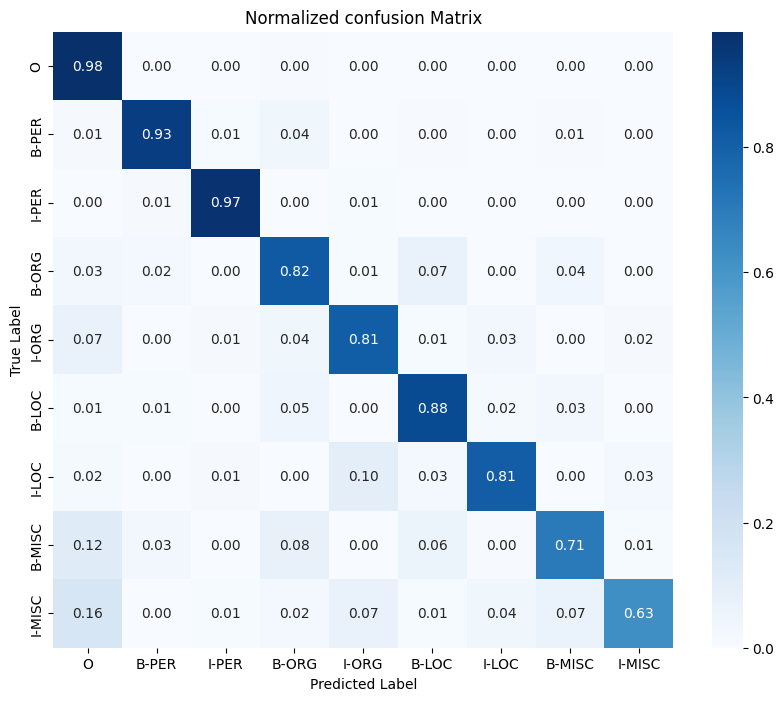

In [ ]:
class_names = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
plot_confusion_matrix(eval_results['eval_confusion_matrix'], class_names)